Here, I do some further EDA and design a Bokeh visual which can later be used and manipulated in the Flask app

In [15]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
client = MongoClient()
db = client.bills

In [4]:
df = pd.read_csv('flask_files/bill_details.csv',index_col=[0])

In [5]:
df.topic.unique()

array(['Tax Code', 'Elections', 'Budget', 'Infrastructure', 'Regulations',
       'Health Care', 'Labor / Immigration', 'Natural Resources',
       'Small Business', 'Diplomacy', 'Border', 'Chemical Substances',
       'Civil Law', 'Military', 'Education'], dtype=object)

In [9]:
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

I look for interesting statistics in the data, such as how many bills in each topic became law - Natural Resources has more than three times any other topic - the value counts for the final actions taken on the bills - 90% were never voted on and less than 3% became law - and finally, the distribution of Democrat and Republican bills introduced for each topic. All of these I'll convey in the Flask app.

In [11]:
df[(df.track=='Became Law')].topic.value_counts()

Natural Resources      144
Regulations             48
Diplomacy               26
Budget                  25
Health Care             25
Border                  21
Infrastructure          19
Civil Law               14
Military                12
Tax Code                12
Small Business           9
Education                8
Chemical Substances      8
Labor / Immigration      6
Elections                1
Name: topic, dtype: int64

In [12]:
df.track.value_counts()

Introduced               13576
Passed House              1133
Became Law                 378
Passed Senate                7
Resolving Differences        6
Failed House                 4
Became Private Law           1
Name: track, dtype: int64

In [13]:
df.party.value_counts()

D    8781
R    6321
I       2
L       1
Name: party, dtype: int64

In [14]:
for topic in df.topic.unique():
    mask = (df.topic==topic)
    print(topic)
    print(df[mask].party.value_counts())

Tax Code
D    898
R    722
Name: party, dtype: int64
Elections
D    230
R     85
Name: party, dtype: int64
Budget
D    288
R    211
Name: party, dtype: int64
Infrastructure
D    964
R    502
Name: party, dtype: int64
Regulations
R    627
D    586
Name: party, dtype: int64
Health Care
D    942
R    629
Name: party, dtype: int64
Labor / Immigration
D    415
R    300
Name: party, dtype: int64
Natural Resources
R    752
D    604
Name: party, dtype: int64
Small Business
D    458
R    388
Name: party, dtype: int64
Diplomacy
D    350
R    210
Name: party, dtype: int64
Border
D    528
R    474
I      1
Name: party, dtype: int64
Chemical Substances
D    481
R    374
I      1
Name: party, dtype: int64
Civil Law
D    746
R    470
L      1
Name: party, dtype: int64
Military
D    424
R    304
Name: party, dtype: int64
Education
D    867
R    273
Name: party, dtype: int64


Here, I convert my data into something I can use in a heat map to convey how many bills in each topic were introduced / became law, every month.

In [16]:
time_df = df.groupby(['topic',df['date'].dt.strftime('%Y-%m')]).size().unstack(fill_value=0)

In [17]:
time_law_df = df[df.track=='Became Law'].groupby(['topic',df['date'].dt.strftime('%Y-%m')]).size().unstack(fill_value=0)

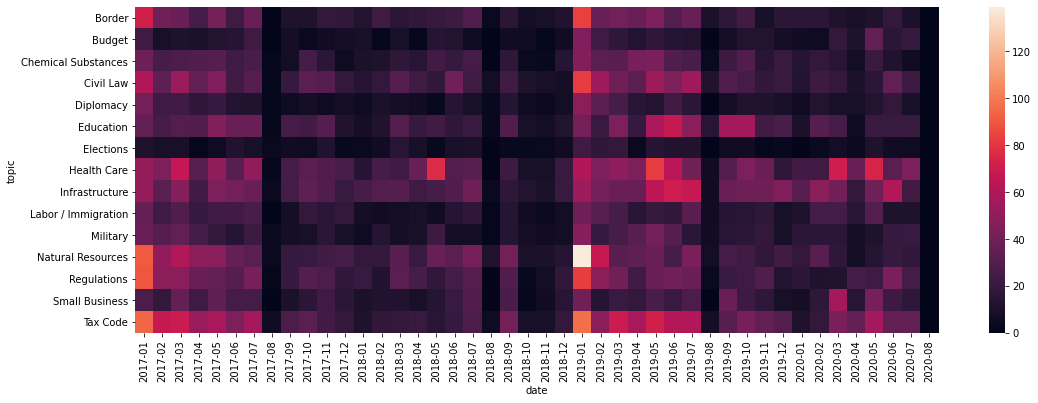

In [18]:
plt.figure(figsize=(18,6))
sns.heatmap(time_df)

I now put together something very similar using Bokeh and supply hover tools. This can be included in the Flask app.

In [21]:
from bokeh.io import show
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, PrintfTickFormatter
from bokeh.plotting import figure

In [22]:
from bokeh.io import output_file, show
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, ColumnDataSource, PrintfTickFormatter
from bokeh.plotting import figure
from bokeh.transform import transform

In [23]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [24]:
time_df = df[(df.track=='Became Law')].groupby([df['date'].dt.strftime('%Y-%m'),'topic']).size().unstack(fill_value=0)

In [25]:
time_df.index.name = 'Months'
time_df.columns.name = 'Topics'

time_df = time_df.stack().rename("value").reset_index()

colors = ['#000000','#330000','#6F0606', '#C32B2B','#F31E1E','#FF9406','#FC9207','#F5C88D','#FFFF01',
              '#FAF44B','#F0F974','#DCDCC8','#F7F7EB']
mapper = LinearColorMapper(
    palette=colors, low=time_df.value.min(), high=time_df.value.max())

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"
p = figure(
    plot_width=800,
    plot_height=300,
    title="My plot",
    x_range=list(time_df.Months.drop_duplicates()),
    y_range=list(time_df.Topics.drop_duplicates()),
    tools=TOOLS, toolbar_location='below',
           tooltips=[('Month', '@Months'), ('Bills', '@value')],
    x_axis_location="below")
# Create rectangle for heatmap
p.rect(
    x="Months",
    y="Topics",
    width=1,
    height=1,
    source=ColumnDataSource(time_df),
    line_color=None,
    fill_color=transform('value', mapper))
# Add legend
color_bar = ColorBar(
    color_mapper=mapper,
    location=(0, 0),
    ticker=BasicTicker(desired_num_ticks=len(colors)))

p.add_layout(color_bar, 'right')
p.xaxis.major_label_orientation = 0.8
show(p)